In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [31]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

%matplotlib inline

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np

from Bio.Seq import Seq

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
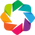

In [20]:
# General imports
import glob
import os
import re
import pickle
import datetime
import pathlib

# Data manipulation
# import growth_analysis as ga
import pandas as pd
pd.set_option('display.max_columns', 40)
import numpy as np

# Basic plotting
import holoviews as hv
import bokeh
from bokeh.io import export_svg
from bokeh.themes.theme import Theme
theme = Theme(
    json = {
    'attrs' : {
        'Title': {
            'align':'center',
            'text_font_size':'15px',
            'text_color':'black',
            'text_font': 'arial'
        },       # title centered and bigger
        'Axis': {
            'axis_label_text_font_style': 'normal',
            'axis_label_text_color':'black',
            'major_label_text_color':'black',
            'axis_label_text_font': 'arial',
            'major_label_text_font': 'arial',
        },          # no italic labels 
        'Legend': {
            'title_text_font_style': 'normal',
            'title_text_color':'black',
            'label_text_color':'black',
            'label_text_font': 'arial',
        },
        'ColorBar': {
            'title_text_font_style': 'normal',
            'major_label_text_color':'black',
            'major_label_text_font': 'arial',
            'title_text_color':'black',
            'title_text_font': 'arial',
        },
    }
}
)

hv.extension('bokeh')
hv.renderer('bokeh').theme = theme

import panel as pn
pn.config.comms = "vscode"

# Large data plotting
import datashader as ds
from holoviews.operation.datashader import datashade, rasterize

# Making graphs
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from tqdm.auto import tqdm
from multiprocessing import Pool

from SSMuLA.landscape_info import LIB_INFO_DICT
from SSMuLA.vis import save_bokeh_hv, PRESENTATION_PALETTE_SATURATE6

In [5]:
class ProcessDHFR:
    """
    Class to clean up the DHFR data
    """

    def __init__(self, input_csv: str = "data/DHFR/fitness_landscape/DHFR.csv") -> None:

        """
        Args:
        - input_csv: str: path to the input csv file
        """

        self._input_csv = input_csv
        
        
    @property
    def lib_info(self) -> dict:
        """Return the library information"""
        return LIB_INFO_DICT["DHFR"]
    
    @property
    def split_AA_cols(self) -> list:
        """Return the columns for the split amino acids"""
        return [f"AA{str(i)}" for i in self.lib_info["positions"].keys()]
    
    @property
    def input_df(self) -> pd.DataFrame:
        """Return the input dataframe"""
        return pd.read_csv(self._input_csv)
    
    @property
    def df_aa(self) -> pd.DataFrame:
        """Return the input dataframe with amino acid translations"""

        df = self.input_df.copy()

        # Translate the sequence to amino acids
        df["AAs"] = df["seq"].apply(lambda x: "".join(Seq(x).translate()))

        return df[["AAs", "seq", "fitness"]].copy()
    
    @property
    def df_split_aa(self) -> pd.DataFrame:
        """Return the input dataframe with amino acid translations
        and split into individual amino acids"""

        df = self.df_aa.copy()

        # Split combo into individual amino acids 
        df[self.split_AA_cols] = df["AAs"].apply(lambda x: pd.Series(list(x)))

        return df[["AAs", *self.split_AA_cols, "seq", "fitness"]].copy()
    
    @property
    def df_avg_aa(self) -> pd.DataFrame:
        """Return the average fitness of each amino acid"""

        df = self.df_aa.copy()[["AAs", "fitness"]]
        # Group by amino acid and take the average fitness
        df = df.groupby("AAs")["fitness"].mean().reset_index()
        # Split combo into individual amino acids 
        df[self.split_AA_cols] = df["AAs"].apply(lambda x: pd.Series(list(x)))
        return df[["AAs", *self.split_AA_cols, "fitness"]].copy()

In [17]:
ProcessDHFR().df_avg_aa

,AAs,AA1,AA2,AA3,fitness
0,***,*,*,*,-0.726347
1,**A,*,*,A,-0.748223
2,**C,*,*,C,-0.750235
3,**D,*,*,D,-0.737349
4,**E,*,*,E,-0.739465
...,...,...,...,...,...
9256,YYS,Y,Y,S,-0.712637
9257,YYT,Y,Y,T,-0.730895
9258,YYV,Y,Y,V,-0.722095
9259,YYW,Y,Y,W,-0.760234


In [18]:
ProcessDHFR().input_df["seq"].nunique()

261333

In [23]:
dhfr_fitclass = ProcessDHFR()

codon_df = ProcessDHFR().input_df
avg_aa_df = ProcessDHFR().df_avg_aa

codon_fit = codon_df["fitness"]
aa_fit = avg_aa_df["fitness"]

# Create the first distribution plot
dist1 = (
    hv.Distribution(codon_fit, label="Codon-level").opts(
        width=400,
        height=400,
        color=PRESENTATION_PALETTE_SATURATE6["blue"],
        line_color=None,
    )
    * hv.Spikes([codon_fit.mean()], label="Mean codon fitness").opts(
        line_dash="dotted", line_color=PRESENTATION_PALETTE_SATURATE6["blue"], line_width=1.6
    )  # for label
    * hv.Spikes([codon_fit.median()], label="Median codon fitness").opts(
        line_color=PRESENTATION_PALETTE_SATURATE6["blue"], line_width=1.6
    )
)

# Create the second distribution plot
dist2 = (
    hv.Distribution(aa_fit, label="AA-level").opts(
        color=PRESENTATION_PALETTE_SATURATE6["orange"],
        line_color=None,
    )
    * hv.Spikes([aa_fit.mean()], label="Mean AA fitness").opts(
        line_dash="dotted", line_color=PRESENTATION_PALETTE_SATURATE6["orange"], line_width=1.6
    )
    * hv.Spikes([aa_fit.median()], label="Median AA fitness").opts(
        line_color=PRESENTATION_PALETTE_SATURATE6["orange"], line_width=1.6
    )
)

# Overlay the two plots
overlay_dist = dist1 * dist2

# Customize the plot options
overlay_dist.opts(
    legend_position="top_right",
    title="DHFR fitness distribution",
    xlabel="Fitness",
)  # ylabel='Frequency')

# Display the plot with the legend
save_bokeh_hv(
    overlay_dist,
    plot_name="DHFR fitness distribution",
    plot_path="results/fitness_distribution",
    bokehorhv = "hv",
    # dpi: int = 300,
    # scale: float = 1,
    )

In [57]:
df_split_aa = ProcessDHFR().df_split_aa

In [58]:
site_counts = df_split_aa.groupby(["AAs", "AA1", "AA2", "AA3"], as_index=True).count().reset_index()
site_counts

,AAs,AA1,AA2,AA3,seq,fitness
0,***,*,*,*,27,27
1,**A,*,*,A,36,36
2,**C,*,*,C,18,18
3,**D,*,*,D,18,18
4,**E,*,*,E,18,18
...,...,...,...,...,...,...
9256,YYS,Y,Y,S,24,24
9257,YYT,Y,Y,T,16,16
9258,YYV,Y,Y,V,16,16
9259,YYW,Y,Y,W,4,4


In [67]:
from SSMuLA.param import TRANSLATE_DICT, CODON_COUNT_PER_AA

In [69]:
df_split_aa['Counts'] = df_split_aa.groupby('AAs')["AAs"].transform('count')
count_aa = df_split_aa[["AAs", "AA1", "AA2", "AA3", "Counts"]].drop_duplicates().sort_values("AAs").reset_index(drop=True)
count_aa["Norm_counts"] = count_aa.apply(lambda row: row["Counts"] / (CODON_COUNT_PER_AA[row["AA1"]] * CODON_COUNT_PER_AA[row["AA2"]] * CODON_COUNT_PER_AA[row["AA3"]]), axis=1)
count_aa

,AAs,AA1,AA2,AA3,Counts,Norm_counts
0,***,*,*,*,27,1.0
1,**A,*,*,A,36,1.0
2,**C,*,*,C,18,1.0
3,**D,*,*,D,18,1.0
4,**E,*,*,E,18,1.0
...,...,...,...,...,...,...
9256,YYS,Y,Y,S,24,1.0
9257,YYT,Y,Y,T,16,1.0
9258,YYV,Y,Y,V,16,1.0
9259,YYW,Y,Y,W,4,1.0


In [72]:
count_aa.Norm_counts.unique()

array([1.        , 0.97916667, 0.99074074, 0.98611111, 0.953125  ,
       0.96875   , 0.921875  , 0.984375  , 0.9375    , 0.875     ,
       0.98958333, 0.99305556, 0.95833333, 0.97222222, 0.94791667,
       0.90625   , 0.89583333, 0.78125   , 0.92708333, 0.75      ,
       0.91666667, 0.84375   , 0.85416667, 0.98148148, 0.99537037,
       0.96527778])

<Axes: xlabel='AAs'>

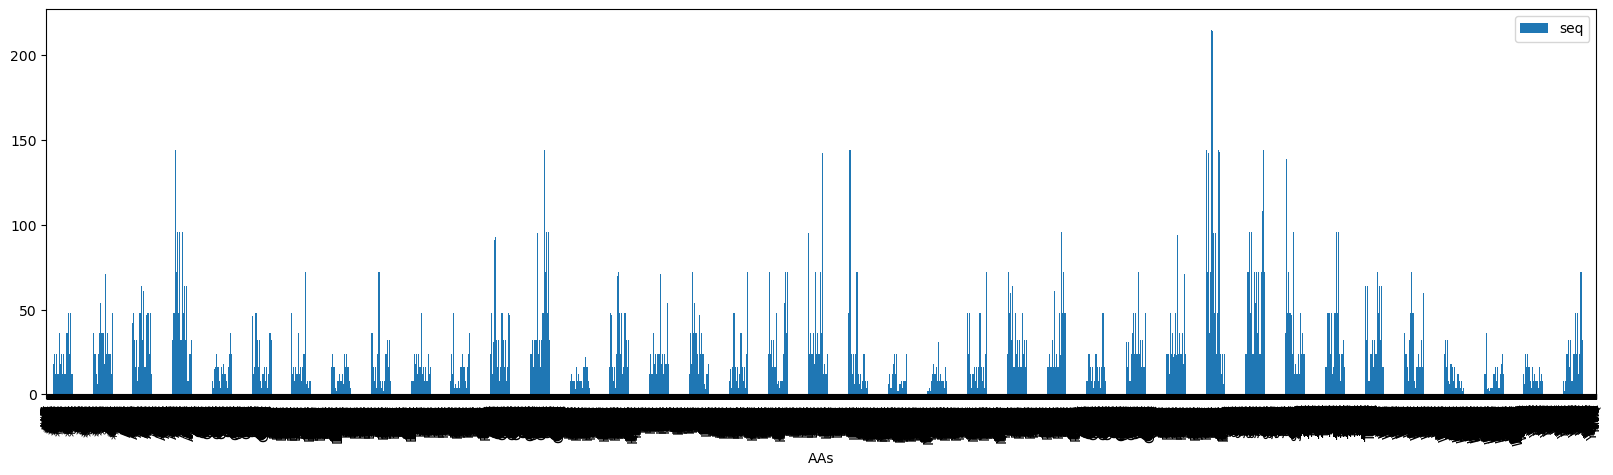

In [47]:
site_counts_df = site_counts.to_frame()
site_counts_df.plot(kind='bar', figsize=(20, 5))

In [74]:
aa_stop_df = avg_aa_df[avg_aa_df["AAs"].str.contains("\*")]
aa_stop_df

,AAs,AA1,AA2,AA3,fitness
0,***,*,*,*,-0.726347
1,**A,*,*,A,-0.748223
2,**C,*,*,C,-0.750235
3,**D,*,*,D,-0.737349
4,**E,*,*,E,-0.739465
...,...,...,...,...,...
9156,YS*,Y,S,*,-0.731009
9177,YT*,Y,T,*,-0.734849
9198,YV*,Y,V,*,-0.713336
9219,YW*,Y,W,*,-0.725181


In [81]:
# calc active vs inactive based on 1.96 std > mean fitness

avg_stop = aa_stop_df["fitness"].mean()
std_stop = aa_stop_df["fitness"].std()
fit_min = 1.96 * std_stop + avg_stop

print('95%', len(avg_aa_df.loc[avg_aa_df['fitness'] > fit_min]))

# add column called active if fitness > fit_min
avg_aa_df.loc[avg_aa_df['fitness'] > fit_min, 'active'] = True
avg_aa_df.loc[avg_aa_df['fitness'] <= fit_min, 'active'] = False
avg_aa_df


95% 987


,AAs,AA1,AA2,AA3,fitness,active
0,***,*,*,*,-0.726347,False
1,**A,*,*,A,-0.748223,False
2,**C,*,*,C,-0.750235,False
3,**D,*,*,D,-0.737349,False
4,**E,*,*,E,-0.739465,False
...,...,...,...,...,...,...
9256,YYS,Y,Y,S,-0.712637,False
9257,YYT,Y,Y,T,-0.730895,False
9258,YYV,Y,Y,V,-0.722095,False
9259,YYW,Y,Y,W,-0.760234,False


In [85]:
# active percentage
active_percnet = avg_aa_df['active'].value_counts()/len(avg_aa_df)
active_percnet

False    0.893424
True     0.106576
Name: active, dtype: float64